## DuckDB Integration
Load necessary libraries as described in https://duckdb.org/docs/guides/python/jupyter

In [20]:
from sqlalchemy import MetaData, create_engine
from sqlalchemy_schemadisplay import create_schema_graph
import pandas as pd

from pathlib import Path
from IPython.display import Image

def display_schema(engine, outfile):
    """
    Display metadata using SQL Alchemy Schema Display
    """
    m = MetaData(engine)
    # create the pydot graph object by autoloading all tables via a bound metadata object
    graph = create_schema_graph(metadata=m,
        show_datatypes=False, # The image would get nasty big if we'd show the datatypes
        show_indexes=False, # ditto for indexes
        rankdir='LR', # From left to right (instead of top to bottom)
        concentrate=False # Don't try to join the relation lines together
    )
    graph.write_png(outfile) # write out the file
    return Image(filename=outfile)

In [3]:
## Load Jupyter Magics
%load_ext sql

# Import ipython-sql Jupyter extension to create SQL cells
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

/home/matinnu/miniconda3/envs/duckdb/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3194: UserWarning: Config option `displaycon` not recognized by `SqlMagic`.  Did you mean `displaylimit`?
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Choose connection
#%sql duckdb:///:memory:
%sql duckdb:///duckdb.db

'Connected: @duckdb.db'

## Creating Main schema table
First, we merge the two main tables from BGCFlow: `genomes` and `taxa`.
Inspired by the antismash db sql schema https://github.com/antismash/db-schema

In [5]:
%%sql

CREATE TABLE taxa (
    tax_id VARCHAR NOT NULL,
    domain  VARCHAR,
    phylum  VARCHAR,
    class   VARCHAR,
    taxonomic_order   VARCHAR,
    family  VARCHAR,
    genus   VARCHAR,
    species VARCHAR,
    CONSTRAINT taxa_pkey PRIMARY KEY (tax_id)
);

CREATE TABLE genomes (
    genome_id           VARCHAR NOT NULL,
    tax_id            VARCHAR NOT NULL,
    source              VARCHAR,
    strain              VARCHAR,
    bgcs_count          VARCHAR,
    bgcs_on_contig_edge VARCHAR,
    CONSTRAINT genomes_pkey PRIMARY KEY (genome_id),
    CONSTRAINT genomes_tax_id_fkey FOREIGN KEY (tax_id) REFERENCES taxa (tax_id),
    CONSTRAINT chk_source CHECK (source IN ('custom', 'ncbi', 'patric'))
);

 * duckdb:///duckdb.db
(duckdb.CatalogException) Catalog Error: Table with name "taxa" already exists!
[SQL: CREATE TABLE taxa (
    tax_id VARCHAR NOT NULL,
    domain  VARCHAR,
    phylum  VARCHAR,
    class   VARCHAR,
    taxonomic_order   VARCHAR,
    family  VARCHAR,
    genus   VARCHAR,
    species VARCHAR,
    CONSTRAINT taxa_pkey PRIMARY KEY (tax_id)
);]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [27]:
%sql SHOW TABLES;

 * duckdb:///duckdb.db


,name
0,genomes
1,seqfu
2,taxa


## Populate Taxa Table

In [28]:
%%sql
WITH src_taxa AS (
    SELECT * FROM read_csv_auto('../data/df_gtdb_meta.csv', header=True)
),

stg_taxa AS (
    SELECT
        md5(Domain || Phylum || Class || src_taxa.Order || Family || Genus || Organism) AS tax_id,
        genome_id,
        Domain AS domain,
        Phylum AS phylum,
        Class AS class,
        src_taxa.Order AS taxonomic_order,
        Family AS family,
        Genus AS genus,
        Organism AS species,
    FROM src_taxa
)

INSERT INTO taxa (tax_id, domain, phylum, class, taxonomic_order, family, genus, species)
    SELECT DISTINCT tax_id, domain, phylum, class, taxonomic_order, family, genus, species 
    FROM stg_taxa;

 * duckdb:///duckdb.db


IntegrityError: (duckdb.ConstraintException) Constraint Error: duplicate key "tax_id: 654beafd7c58d4fd0e8dee18a4150eab" violates primary key constraint
[SQL: WITH src_taxa AS (
    SELECT * FROM read_csv_auto('../data/df_gtdb_meta.csv', header=True)
),

stg_taxa AS (
    SELECT
        md5(Domain || Phylum || Class || src_taxa.Order || Family || Genus || Organism) AS tax_id,
        genome_id,
        Domain AS domain,
        Phylum AS phylum,
        Class AS class,
        src_taxa.Order AS taxonomic_order,
        Family AS family,
        Genus AS genus,
        Organism AS species,
    FROM src_taxa
)

INSERT INTO taxa (tax_id, domain, phylum, class, taxonomic_order, family, genus, species)
    SELECT DISTINCT tax_id, domain, phylum, class, taxonomic_order, family, genus, species 
    FROM stg_taxa;]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

/home/matinnu/miniconda3/envs/duckdb/lib/python3.9/site-packages/duckdb_engine/__init__.py:229: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


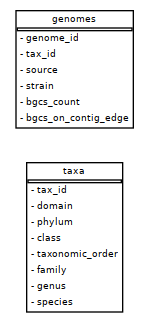

In [29]:
engine = create_engine("duckdb:///duckdb.db")
display_schema(engine, 'schema.png')

In [9]:
%sql SELECT DISTINCT genus FROM taxa;

 * duckdb:///duckdb.db


,genus
0,g__Streptomyces


## Populate genome table with relations to taxa

In [10]:
%%sql
WITH src_taxa AS (
    SELECT * FROM read_csv_auto('../data/df_gtdb_meta.csv', header=True)
),

src_genomes AS (
    SELECT * FROM "../data/df_antismash_6.1.1_summary.csv"
),

stg_taxa AS (
    SELECT
        md5(Domain || Phylum || Class || src_taxa.Order || Family || Genus || Organism) AS tax_id,
        genome_id,
    FROM src_taxa
),

stg_genomes AS(
    SELECT 
        src_genomes.genome_id, 
        src_genomes.source,
        src_genomes.strain,
        src_genomes.bgcs_count,
        src_genomes.bgcs_on_contig_edge ,
        stg_taxa.tax_id
    FROM src_genomes, stg_taxa
    WHERE
        src_genomes.genome_id = stg_taxa.genome_id
)

INSERT INTO genomes (genome_id, tax_id, source, strain, bgcs_count, bgcs_on_contig_edge)
    SELECT genome_id, tax_id, source, strain, bgcs_count, bgcs_on_contig_edge
    FROM stg_genomes;

 * duckdb:///duckdb.db


,Count
0,27


In [11]:
%sql SELECT * FROM genomes WHERE bgcs_on_contig_edge > 0;

 * duckdb:///duckdb.db


,genome_id,tax_id,source,strain,bgcs_count,bgcs_on_contig_edge
0,P5-2B-15,654beafd7c58d4fd0e8dee18a4150eab,custom,P5-2B-15,38.0,1.0
1,P5-A5,9699895deb16dc9cf79099ae5cb4e1a0,custom,P5-A5,27.0,5.0
2,P9-A3,9699895deb16dc9cf79099ae5cb4e1a0,custom,P9-A3,20.0,1.0
3,P9-A5,9699895deb16dc9cf79099ae5cb4e1a0,custom,P9-A5,15.0,1.0
4,P9-A9,9699895deb16dc9cf79099ae5cb4e1a0,custom,P9-A9,18.0,1.0
5,P9-A2,9699895deb16dc9cf79099ae5cb4e1a0,custom,P9-A2,29.0,1.0


## Generate Seqfu Table
We will use auto increment method as explained in https://github.com/duckdb/duckdb/issues/1768

In [12]:
%%sql
CREATE SEQUENCE seq_seqfuid START 1;

 * duckdb:///duckdb.db


""


In [13]:
%%sql
CREATE TABLE seqfu (
    seqfu_id INTEGER NOT NULL DEFAULT(nextval('seq_seqfuid')),
    genome_id VARCHAR NOT NULL,
    Min INTEGER,
    N25 INTEGER,
    N50 INTEGER,
    AuN REAL,
    gc REAL,
    Max INTEGER,
    N75 INTEGER,
    Count INTEGER,
    Total INTEGER,
    N90 INTEGER,
    Avg REAL,
    CONSTRAINT seqfu_pkey PRIMARY KEY (seqfu_id),
    CONSTRAINT seqfu_genome_id_fkey FOREIGN KEY (genome_id) REFERENCES genomes (genome_id)
);

 * duckdb:///duckdb.db


""


## Populate Seqfu Table

In [14]:
%%sql 
INSERT INTO seqfu (genome_id, Min, N25, N50, AuN, gc, 
                   Max, N75, Count, Total, N90, Avg)
SELECT
    genome_id, Min, N25, N50, AuN, gc, 
    Max, N75, Count, Total, N90, Avg
FROM '../data/df_seqfu_stats.csv'

 * duckdb:///duckdb.db


,Count
0,27


/home/matinnu/miniconda3/envs/duckdb/lib/python3.9/site-packages/duckdb_engine/__init__.py:229: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


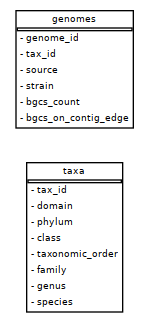

In [26]:
engine = create_engine("duckdb:///duckdb.db")
display_schema(engine, 'schema.png')

In [25]:
engine.table_names()

/tmp/ipykernel_13290/4162273999.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['taxa', 'genomes']

## Queries using foreign keys

In [16]:
%%sql
SELECT G.genome_id, T.species
FROM genomes G
INNER JOIN taxa T
ON G.tax_id = T.tax_id
WHERE G.genome_id LIKE 'P5%'

 * duckdb:///duckdb.db


,genome_id,species
0,P5-2B-15,s__Streptomyces tubercidicus
1,P5-2B-6,s__Streptomyces halstedii
2,P5-A9,s__Streptomyces sp002711365
3,P5-A5,s__
4,P5-A2,s__Streptomyces sp002711365
5,P5-A3,s__


In [17]:
%%sql
SELECT G.genome_id, S.N50, T.species
FROM genomes G
INNER JOIN seqfu S
ON G.genome_id = S.genome_id
INNER JOIN taxa T
ON G.tax_id = T.tax_id
WHERE G.genome_id LIKE 'P5%'

 * duckdb:///duckdb.db


,genome_id,N50,species
0,P5-2B-15,9001612,s__Streptomyces tubercidicus
1,P5-2B-6,7332070,s__Streptomyces halstedii
2,P5-A9,7671826,s__Streptomyces sp002711365
3,P5-A5,8008365,s__
4,P5-A2,7674445,s__Streptomyces sp002711365
5,P5-A3,8424100,s__


In [19]:
%%sql close

UsageError: %%sql is a cell magic, but the cell body is empty. Did you mean the line magic %sql (single %)?
